Goals:
1. to investigate the parcel and/or zoning information in San Jose and Los Angeles so that we can filter out the single-family residences (SFRs) from the TIFs.
2. to prototype how we could identify ADU/small buildings based on parcel information

In [20]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, box, MultiPolygon
import os
import matplotlib.pyplot as plt
from pyproj import Geod
from shapely.ops import orient

# 1. Filtering out SFRs

### a) San Jose
- R-1: SFR
- R-2: Double Occupancy
- R-M: Residential-Multi

In [3]:
fp = '/oak/stanford/groups/deho/building_compliance/parcels/'

In [4]:
sj_zoning = gpd.read_file(os.path.join(fp, 'san_jose_Zoning_Districts.geojson'))

In [5]:
# R-MH is mobile home
sj_residential = sj_zoning[(sj_zoning['ZONING'].str.contains('R-1')) | (sj_zoning['ZONING'].str.contains('R-2')) |\
         ((sj_zoning['ZONING'].str.contains('R-M')) & (sj_zoning['ZONING'] != 'R-MH'))]

### b) Los Angeles
Zoning in Los Angeles County is a little trickier; the county consists of (mostly) incorporated cities which designate their own zoning rules. Hence, we would have to get the zoning files for the cities that we have NAIP tiles for. The county data download site only has zoning data for unincorporated territories, which is a very small portion of the county. Thankfully, a lot of our tiles intersect with LA city, which we have GIS data for:
- Mid-wilshire: intersects with Culver City (data exists)
- Valley: all LA city
- Torrance: Mostly intersects with small incorporated cities (data doesn't exist)
- South Central: unincorporated, LA city, hawthorne, inglewood (latter two doesn't exist)

In [30]:
mid_wilshire = box(-118.42264979853323, 34.020425261173386, -118.3274039386137, 34.051457250941674)
valley = box(-118.5947617037504, 34.1518934898276, -118.40286108520485, 34.278004449211494)
torrance = box(-118.38894671860481, 33.76190036981278, -118.26456955803374, 33.837507964798)
south_central = box(-118.36618406252838, 33.92399439434224, -118.24340101311658, 34.01043519525057)

In [31]:
la_city_boundaries = gpd.read_file('/oak/stanford/groups/deho/building_compliance/los_angeles/LA_County_city_boundaries.geojson')

In [32]:
la_city_boundaries['mid_wilshire'] = la_city_boundaries['geometry'].apply(lambda x: 1 if x.intersection(mid_wilshire).area > 0 else 0)
la_city_boundaries['valley'] = la_city_boundaries['geometry'].apply(lambda x: 1 if x.intersection(valley).area > 0 else 0)
la_city_boundaries['torrance'] = la_city_boundaries['geometry'].apply(lambda x: 1 if x.intersection(torrance).area > 0 else 0)
la_city_boundaries['south_central'] = la_city_boundaries['geometry'].apply(lambda x: 1 if x.intersection(south_central).area > 0 else 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


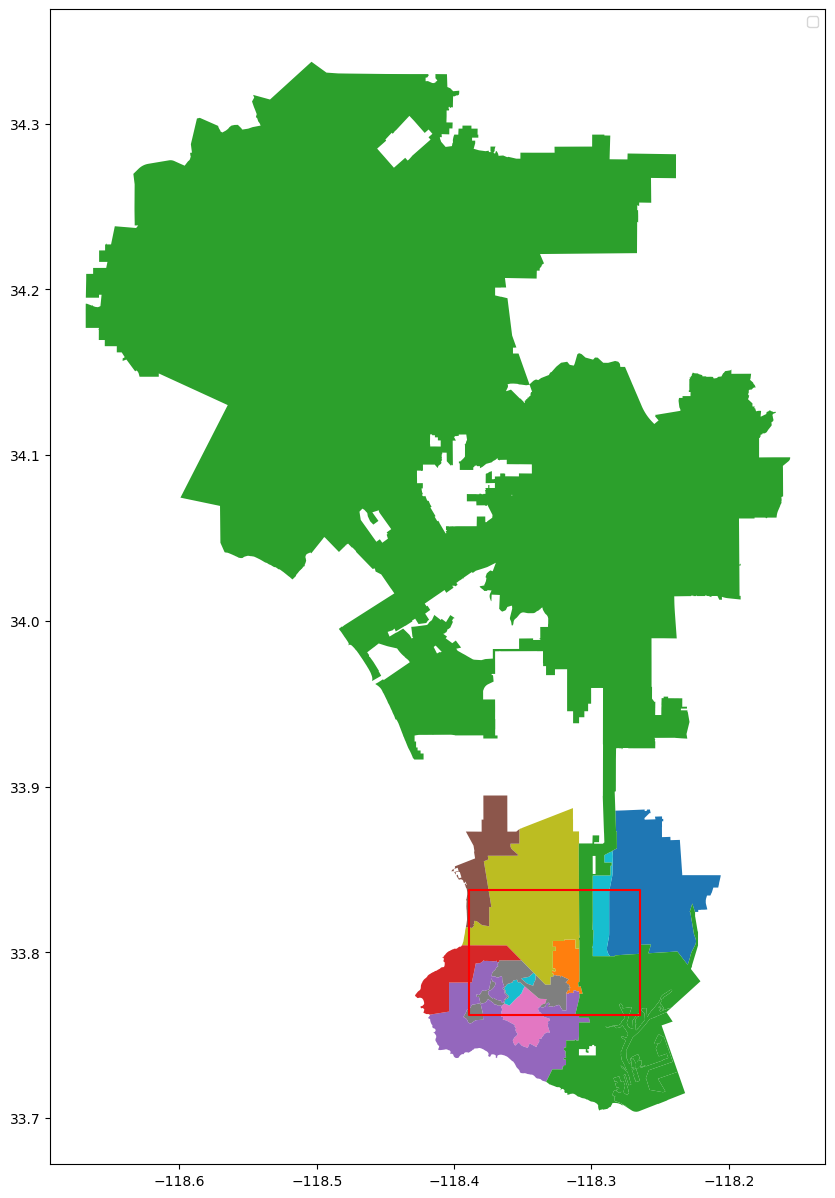

In [33]:
fig, ax = plt.subplots (figsize = (15,15))
# south_central.plot(ax = ax, alpha = 0.7, color = "pink")
la_city_boundaries[la_city_boundaries['torrance'] == 1].plot(ax = ax, column='city_name')
x, y = torrance.exterior.xy
ax.plot(x, y, c="red")
plt.legend()
plt.savefig('torrance.png')
plt.show()

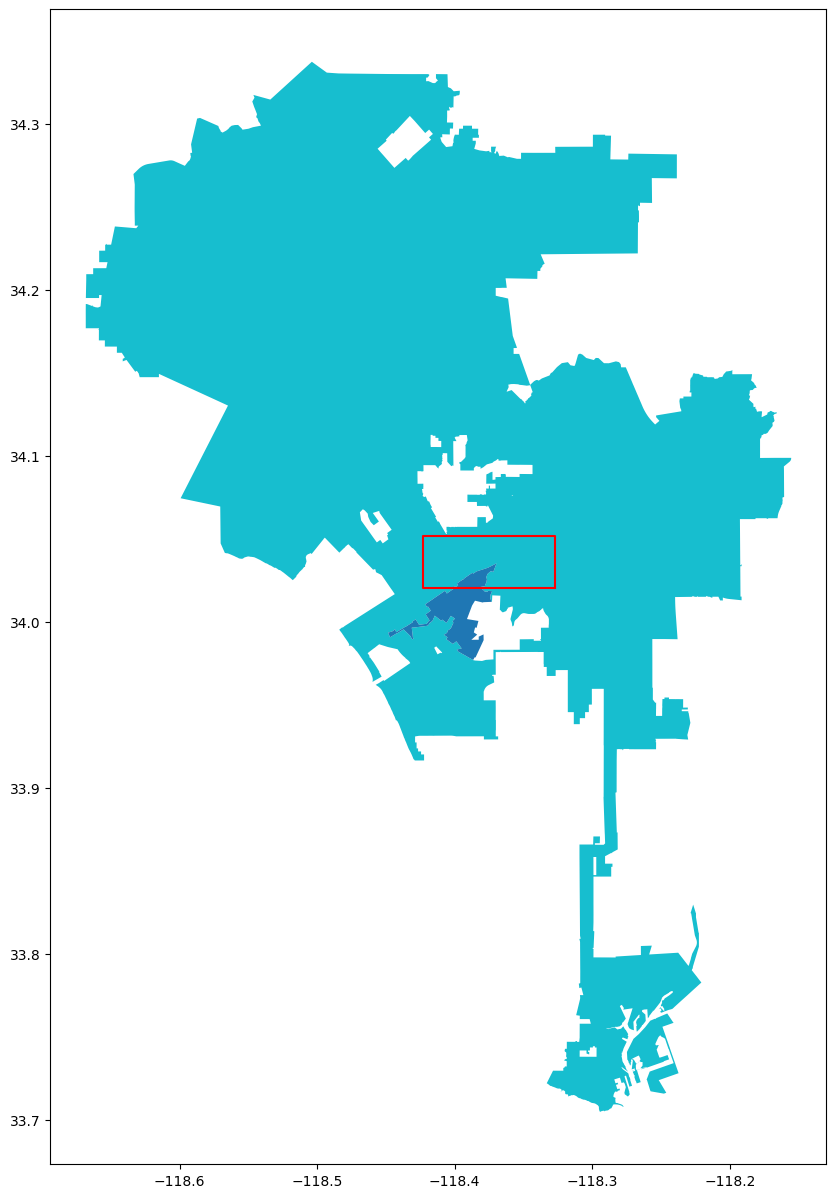

In [34]:
fig, ax = plt.subplots (figsize = (15,15))
# south_central.plot(ax = ax, alpha = 0.7, color = "pink")
la_city_boundaries[la_city_boundaries['mid_wilshire'] == 1].plot(ax = ax, column='city_name')
x, y = mid_wilshire.exterior.xy
ax.plot(x, y, c="red")
plt.savefig('mid_wilshire.png')
plt.show()

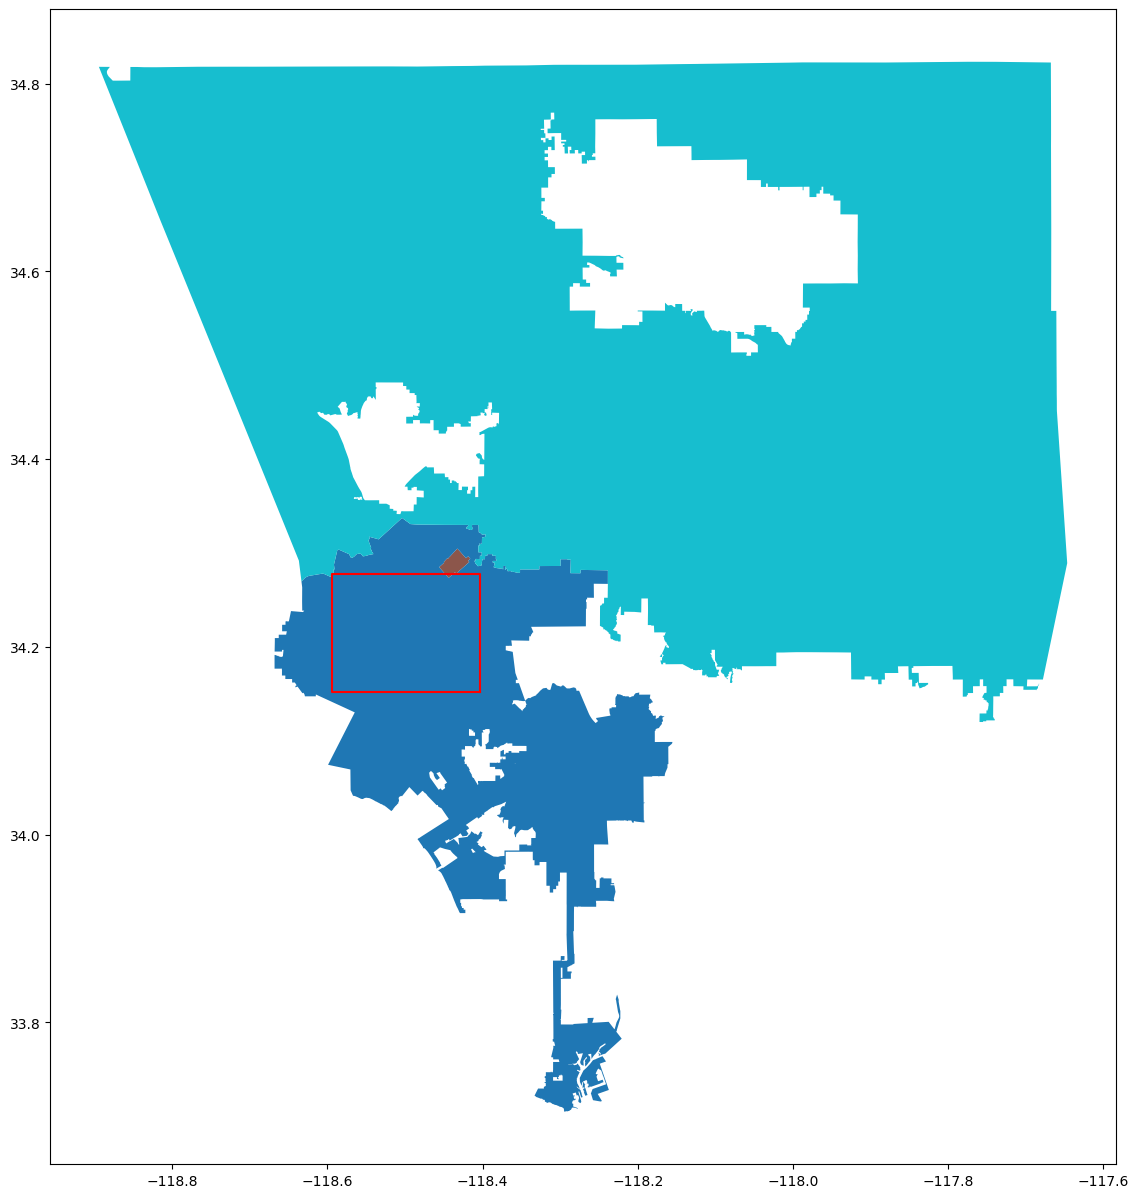

In [35]:
fig, ax = plt.subplots (figsize = (15,15))
# south_central.plot(ax = ax, alpha = 0.7, color = "pink")
la_city_boundaries[la_city_boundaries['valley'] == 1].plot(ax = ax, column='city_name')
x, y = valley.exterior.xy
ax.plot(x, y, c="red")
plt.savefig('valley.png')
plt.show()

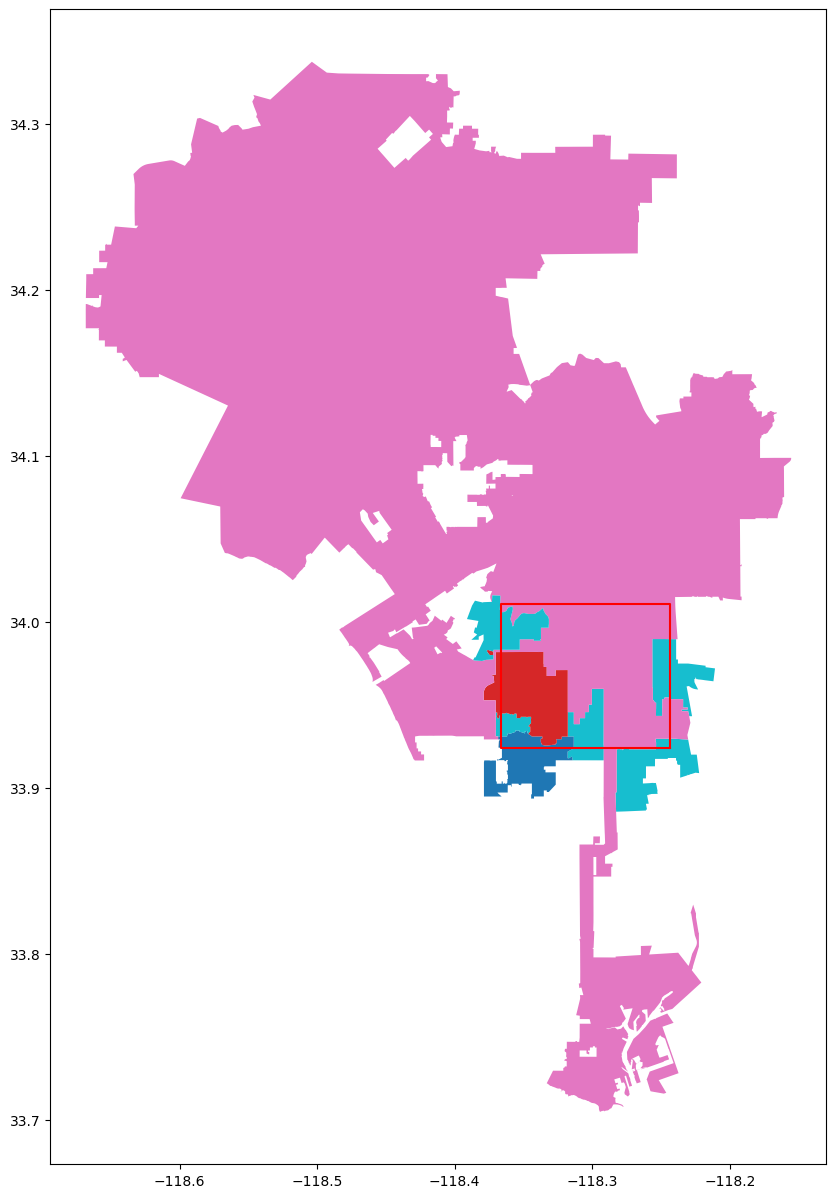

In [36]:
fig, ax = plt.subplots (figsize = (15,15))
# south_central.plot(ax = ax, alpha = 0.7, color = "pink")
la_city_boundaries[la_city_boundaries['south_central'] == 1].plot(ax = ax, column='city_name')
x, y = south_central.exterior.xy
ax.plot(x, y, c="red")
plt.savefig('south_central.png')
plt.show()

In [17]:
la_parcels = gpd.read_file('/oak/stanford/groups/deho/building_compliance/LA_County_Parcels/', 
                           bbox=box(-118.42264979853323, 34.020425261173386, -118.3274039386137, 34.051457250941674))

In [19]:
la_parcels[['UseCode', 'UseCode_2']]

,UseCode,UseCode_2
0,0100,01
1,0104,01
2,0100,01
3,0100,01
4,0100,01
...,...,...
31371,None,None
31372,None,None
31373,None,None
31374,None,None


# 2. [Prototype] Identifying small buildings from parcel information

### a) San Jose

In [2]:
from shapely.ops import unary_union

In [6]:
sj_residential_geom = unary_union(sj_residential['geometry'])

In [8]:
fp = '/oak/stanford/groups/deho/building_compliance/parcels/'
# sj_parcels = gpd.read_file(os.path.join(fp, 'san_jose_parcels_062722.geojson'))

In [9]:
sj_parcels_test = gpd.read_file(os.path.join(fp, 'san_jose_parcels_062722.geojson'),
                               box(-121.89853956729915, 37.307173034752125, -121.89539372338514, 37.30751657882891))

In [10]:
sj_footprints_test = gpd.read_file('../../all_buildings/data/input/OSM/san_jose.geojson',
                             box(-121.89853956729915, 37.307173034752125, -121.89539372338514, 37.30751657882891))

KeyboardInterrupt: 

In [82]:
sj_footprints_test.to_file('test.geojson', index=False)

In [24]:
footprints['iou']

GeoSeries([], Name: iou, dtype: geometry)

In [37]:
sj_parcels_test

,OBJECTID,PARCELID,INTID,APN,LOTNUM,PARCELTYPE,FEATURECLASS,PLANCRT,PLANMOD,LASTUPDATE,NOTES,COVERED,SHAPE_Length,SHAPE_Area,geometry
0,9629,83981,83981,42903043,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,326.690556,6278.320271,"POLYGON ((-121.89532 37.30716, -121.89537 37.3..."
1,9630,83982,83982,42903044,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,365.645014,7174.806985,"POLYGON ((-121.89535 37.30734, -121.89539 37.3..."
2,9637,83983,83983,42903045,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,376.233615,7788.249030,"POLYGON ((-121.89543 37.30747, -121.89551 37.3..."
3,12437,83955,83955,42903016,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,474.974096,10478.653898,"POLYGON ((-121.89503 37.30785, -121.89510 37.3..."
4,12457,83956,83956,42903017,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,472.953557,9470.184181,"POLYGON ((-121.89489 37.30772, -121.89494 37.3..."
5,12458,83957,83957,42903018,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,602.298477,17615.967191,"POLYGON ((-121.89479 37.30762, -121.89535 37.3..."
6,13764,84131,84131,42905055,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,358.499926,6639.484706,"POLYGON ((-121.89816 37.30729, -121.89822 37.3..."
7,13776,84132,84132,42905056,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,369.328495,7200.094458,"POLYGON ((-121.89826 37.30741, -121.89864 37.3..."
8,13777,84133,84133,42905057,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,382.420155,8163.200255,"POLYGON ((-121.89838 37.30756, -121.89851 37.3..."
9,13778,84134,84134,42905083,None,Tax,Parcel,MGE,None,2005-10-25T12:21:45+00:00,None,None,342.242162,5570.708749,"POLYGON ((-121.89845 37.30767, -121.89863 37.3..."


In [29]:
# dic = {parcelid: {main: footprint_index, small: [footprint_index], other: [footprint_index]}}
dic = {}

for idx, row in sj_parcels_test.iterrows():
    footprints = gpd.read_file('test.geojson', mask=row['geometry'])
    # filter footprints that just border parcel
    
    if not footprints.empty:
        footprints['iou'] = footprints['geometry'].apply(lambda x: x.intersection(row['geometry']).area/x.area)
#         print(footprints['iou'])
        footprints = footprints[footprints['iou'] > 0.8]
        if not footprints.empty:
            if len(footprints) > 1:
                geod = Geod(ellps="WGS84")
                # apply orient() before passing to Geod so that the area is not negative
                footprints['area'] = footprints['geometry'].apply(lambda x: geod.geometry_area_perimeter(orient(x))[0])
                print(footprints)
                
                
                # take the max-area footprint -- this is the main building
                max_idx = footprints[footprints['area'] == footprints['area'].max()]
                # APPEND to some master dataset
                
                # categorize the rest
                rest = footprints[~footprints['area'] == footprints['area'].max()]
                
                # heuristic:
                # - anything <20m^2 is too small?
                # - ADUs must be <92m^2 (<1000sqft) according to CA state law
                """
                In CA, ADU's can be up to 800sqft for a 1 bedroom and up to 1000 sqft for a 2 bedroom. Some cities,
                like Los Angeles, allows for ADUs up to 1200 sqft
                
                - ADUs must be  >14m^2 (> 150 sqft) according to CA state law -- (minimum for an efficiency unit defined in Section 17958.1)
                but this seems incredibly small lol
                """
                # ADUs must be  >14m^2 (> 150 sqft) according to CA state law -- (minimum for an efficiency unit defined in Section 17958.1)
                
                # Maybe a good heuristic is [15, 115m^2]
                adu_footprints = rest[(rest['area'] >= 15) & (rest['area'] <= 100)]
                other_footprints = rest[~((rest['area'] >= 15) & (rest['area'] <= 100))]
                if not adu_footprints.empty:
                    # APPEND to some master dataset
                    
                else:
                    
                    
                
                

       index                                           geometry  iou  \
0  835414309  POLYGON ((-121.89576 37.30738, -121.89579 37.3...  1.0   
1  835414314  POLYGON ((-121.89557 37.30741, -121.89560 37.3...  1.0   

         area  
0  232.227581  
1   62.324524  
       index                                           geometry  iou  \
1  835414156  POLYGON ((-121.89819 37.30720, -121.89822 37.3...  1.0   
2  835414155  POLYGON ((-121.89837 37.30703, -121.89842 37.3...  1.0   

         area  
1   34.091910  
2  187.102296  
       index                                           geometry  iou  \
0  835414162  POLYGON ((-121.89858 37.30731, -121.89861 37.3...  1.0   
1  835414160  POLYGON ((-121.89837 37.30737, -121.89840 37.3...  1.0   

         area  
0  182.851165  
1   63.254329  
       index                                           geometry  iou  \
0  835414105  POLYGON ((-121.89683 37.30703, -121.89684 37.3...  1.0   
1  835414112  POLYGON ((-121.89667 37.30720, -121.89671 37.3.

### b) Los Angeles

In [ ]:
la_parcels = gpd.read_file('/oak/stanford/groups/deho/building_compliance/LA_County_Parcels/', 
                           bbox=box(-118.42264979853323, 34.020425261173386, -118.3274039386137, 34.051457250941674))

In [ ]:
la_footprints = gpd.read_file('data/los_angeles/la_select_footprints.geojson')